# Simple Bi-directional LSTM for Sequence Classification

Inspired by [this post](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

In [1]:
import numpy as np


## Sequence Classification Problem
We will define a simple sequence classification problem to explore bidirectional LSTMs.

The problem is defined as a sequence of random values between 0 and 1. This sequence is taken as input for the problem with each number provided one per timestep.

A binary label (0 or 1) is associated with each input. The output values are all 0. Once the cumulative sum of the input values in the sequence exceeds a threshold, then the output value flips from 0 to 1.

A threshold of 1/4 the sequence length is used.

For example, below is a sequence of 10 input timesteps (X):

    0.63144003 0.29414551 0.91587952 0.95189228 0.32195638 0.60742236 0.83895793 0.18023048 0.84762691 0.29165514

The corresponding classification output (y) would be:

    0 0 0 1 1 1 1 1 1 1

In [6]:
def sequence_generator(batch_size, seq_size):
    while 1:
        limit = seq_size / 4.0

        X = np.random.rand(batch_size,seq_size).astype(np.float32)
        Y = np.array([[0 if _x<limit else 1 for _x in np.cumsum(x)] for x in X])

        #reshape the arrays to fit LSTM input shape
        X = X.reshape(batch_size, seq_size, 1)
        Y = Y.reshape(batch_size, seq_size, 1)
        
        yield X,Y


## LSTM model

The input layer will have 10 timesteps with 1 feature a piece, input_shape=(10, 1).

The first hidden layer will have 20 memory units and the output layer will be a fully connected layer that outputs one value per timestep. A sigmoid activation function is used on the output to predict the binary value.

A TimeDistributed wrapper layer is used around the output layer so that one value per timestep can be predicted given the full sequence provided as input. This requires that the LSTM hidden layer returns a sequence of values (one per timestep) rather than a single value for the whole input sequence.

Finally, because this is a binary classification problem, the binary log loss (binary_crossentropy in Keras) is used.

The efficient ADAM optimization algorithm is used to find the weights and the accuracy metric is calculated and reported each epoch.

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.metrics import categorical_accuracy as acc

n_timesteps = 10

def LSTM_model(go_backwards=False):
    model = Sequential()
    model.add(LSTM(20, input_shape=(n_timesteps,1), return_sequences=True, go_backwards=go_backwards))
    model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[acc])
    return model

C:\Users\cedro\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend


The model will be trained on 10000 random samples, by batches of 100 sequences and for 10 epochs.

In [31]:
n_epochs = 10
batch_size = 100
n_batches_per_epoch = 10

generator = sequence_generator(batch_size,n_timesteps)

lstm_model = LSTM_model()
lstm_model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs)

Epoch 1/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6801 - categorical_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.6626 - categorical_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6427 - categorical_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6105 - categorical_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5845 - categorical_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.5437 - categorical_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5219 - categorical_accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.4991 - categorical_accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 12ms/step - loss: 0.4694 - categorical_accuracy: 1.0000
E

Evaluate the LSTM model on 1 batch of random samples

In [17]:
lstm_model.evaluate_generator(generator, steps=1)

[0.4257476329803467, 0.9999999403953552]

## BLSTM model

We can now extend the example to demonstrate a Bidirectional LSTM.

We can do this by wrapping the LSTM hidden layer with a Bidirectional layer.

This will create two copies of the hidden layer, one fit in the input sequences as-is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be concatenated.

That means that instead of receiving 10 timesteps of 20 outputs, the TimeDistributed layer will now receive 10 timesteps of 40 (20 units + 20 units) outputs.

In [29]:
from keras.layers import Bidirectional

def BLSTM_model(merge_mode='concat'):
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps,1), merge_mode=merge_mode))
    model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[acc])
    return model

In [32]:
blstm_model = BLSTM_model()
blstm_model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs)

Epoch 1/10
10/10 [==============================] - 0s 30ms/step - loss: 0.6795 - categorical_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6552 - categorical_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6241 - categorical_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 17ms/step - loss: 0.5789 - categorical_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.5064 - categorical_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 0.4075 - categorical_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.3115 - categorical_accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 17ms/step - loss: 0.2608 - categorical_accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 17ms/step - loss: 0.2303 - categorical_accuracy: 1.0000
E

## Compare LSTM to Bidirectional LSTM

In this example, we will compare the performance of traditional LSTMs to a Bidirectional LSTM over time while the models are being trained.

We will compare three different models; specifically:
1. LSTM
2. LSTM with reversed input sequences
3. Bidirectional LSTM

This comparison will help to show that bidirectional LSTMs can in fact add something more than simply reversing the input sequence.

Epoch 1/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6637 - categorical_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.6443 - categorical_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.6220 - categorical_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.5937 - categorical_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5730 - categorical_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.5454 - categorical_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.5168 - categorical_accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.4939 - categorical_accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 11ms/step - loss: 0.4697 - categorical_accuracy: 1.0000
Ep

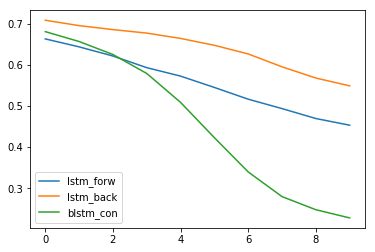

In [36]:
import matplotlib.pyplot as plt
from pandas import DataFrame

results = DataFrame()

# LSTM forward
model = LSTM_model(False)
results['lstm_forw'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# LSTM backward
model = LSTM_model(True)
results['lstm_back'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# BLSTM
model = BLSTM_model('concat')
results['blstm_con'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# line plot of results
results.plot()
plt.show()

## Compare BLSTM merge modes

There a 4 different merge modes that can be used to combine the outcomes of the Bidirectional LSTM layers.

They are concatenation (default), multiplication, average, and sum.

Epoch 1/10
10/10 [==============================] - 0s 32ms/step - loss: 0.6798 - categorical_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.6461 - categorical_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 0.6025 - categorical_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.5383 - categorical_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.4473 - categorical_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 0.3474 - categorical_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.2711 - categorical_accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 17ms/step - loss: 0.2254 - categorical_accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 17ms/step - loss: 0.2205 - categorical_accuracy: 1.0000
E

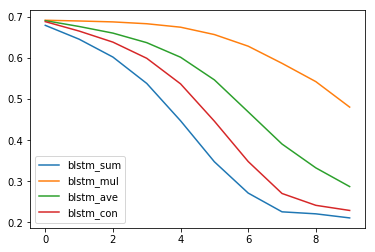

In [37]:
results = DataFrame()

# sum merge
model = BLSTM_model('sum')
results['blstm_sum'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# mul merge
model = BLSTM_model('mul')
results['blstm_mul'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# ave merge
model = BLSTM_model('ave')
results['blstm_ave'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# concat merge
model = BLSTM_model('concat')
results['blstm_con'] = model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs).history['loss']

# line plot of results
results.plot()
plt.show()